In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import imageio
import os
from tqdm import tqdm
import gc
import random
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [14]:
brain_cancer_path = '/kaggle/input/multi-cancer/Multi Cancer/Cervical Cancer'

In [6]:
directories = []
for directory in os.listdir(brain_cancer_path):
    directories.append(directory)
print('Classes Present : ',list(directories))

Classes Present :  ['brain_tumor', 'brain_glioma', 'brain_menin']


In [7]:
brain_tumor_files = []
brain_glioma_files = []
brain_menin_files = []
for directory in directories:
    for files in os.listdir(os.path.join(brain_cancer_path,directory)):
        if directory == 'brain_tumor':
            brain_tumor_files.append(os.path.join(brain_cancer_path,'brain_tumor',files))
        elif directory == 'brain_glioma':
            brain_glioma_files.append(os.path.join(brain_cancer_path,'brain_glioma',files))
        elif directory == 'brain_menin':
            brain_menin_files.append(os.path.join(brain_cancer_path,'brain_menin',files))

In [8]:
print('Brain Tumor Files : ',len(brain_tumor_files))
print('Brain Glioma Files : ',len(brain_glioma_files))
print('Brain Menin Files : ',len(brain_menin_files))

Brain Tumor Files :  5000
Brain Glioma Files :  5000
Brain Menin Files :  5000


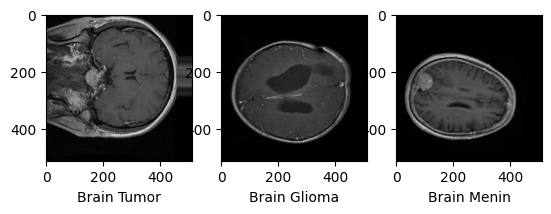

In [9]:
random_num = random.randint(0,len(brain_tumor_files))
brain_tumor_pic = brain_tumor_files[random_num]
brain_glioma_pic = brain_glioma_files[random_num]
brain_menin_pic = brain_menin_files[random_num]
brain_tumor_data = imageio.imread(brain_tumor_pic)
brain_glioma_data = imageio.imread(brain_glioma_pic)
brain_menin_data = imageio.imread(brain_menin_pic)
fig,axs = plt.subplots(1,3)
axs[0].imshow(brain_tumor_data)
axs[1].imshow(brain_glioma_data)
axs[2].imshow(brain_menin_data)
axs[0].set_xlabel('Brain Tumor')
axs[1].set_xlabel('Brain Glioma')
axs[2].set_xlabel('Brain Menin')
plt.show()

In [10]:
gc.collect()

217

In [11]:
generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [15]:
train_ds = generator.flow_from_directory(
    brain_cancer_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
val_ds = generator.flow_from_directory(
    brain_cancer_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 16000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.


In [16]:
print(train_ds.class_indices)

{'all_benign': 0, 'all_early': 1, 'all_pre': 2, 'all_pro': 3}


In [6]:
checkpoint_filepath = '/kaggle/working/checkpoints'
callback = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)
]

In [21]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_resnet.layers:
    layer.trainable = False
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model_resnet.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(train_ds,verbose = 1,epochs = 3,batch_size = 32,validation_data = val_ds,callbacks = callback)

Epoch 1/3
625/625 [==============================] - 219s 299ms/step - loss: 0.1708 - accuracy: 0.9394 - val_loss: 0.0740 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 2/3
625/625 [==============================] - 142s 228ms/step - loss: 0.0485 - accuracy: 0.9833 - val_loss: 0.0672 - val_accuracy: 0.9772 - lr: 0.0010
Epoch 3/3
625/625 [==============================] - 140s 224ms/step - loss: 0.0315 - accuracy: 0.9898 - val_loss: 0.0197 - val_accuracy: 0.9936 - lr: 0.0010


In [25]:
model.evaluate(val_ds)

157/157 [==============================] - 29s 182ms/step - loss: 0.0179 - accuracy: 0.9932


[0.017941126599907875, 0.9932000041007996]

In [23]:
# Generate predictions for the validation dataset using the trained model.
predictions = model.predict(val_data)

# Extract predicted labels by finding the indices of the highest probability in each prediction array.
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the validation data generator.
true_labels = val_data.classes

# Import the 'confusion_matrix' function from sklearn.metrics to create a confusion matrix.
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix to visualize the model's performance.
cm = confusion_matrix(true_labels, predicted_labels)

# Import necessary libraries for visualization: matplotlib and seaborn.
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix as a heatmap with annotations.
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [ ]:
# Generate predictions for the validation dataset using the trained model.
predictions = model.predict(val_data)

# Extract predicted labels by finding the indices of the highest probability in each prediction array.
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the validation data generator.
true_labels = val_data.classes

# Import the 'classification_report' function from sklearn.metrics to generate a classification report.
from sklearn.metrics import classification_report

# Generate a classification report comparing true labels with predicted labels.
# 'target_names' parameter maps numerical class indices to their corresponding class names.
report = classification_report(true_labels, predicted_labels, target_names=val_data.class_indices.keys())

# Print the classification report to evaluate the model's performance.
print(report)



In [ ]:

img='/content/multi-cancer/Multi Cancer/ALL/all_pre/all_pre_0002.jpg'
import cv2
#Defines a function called predict_disease that takes a test image file path as input,
#preprocesses the image, makes predictions using the trained model, and returns the predicted class label.
def predict_disease(test_image):
    # Read the image using OpenCV and normalize pixel values to the range [0, 1].
    img = cv2.imread(test_image)
    img = img / 255.0

    # Resize the image to match the input size expected by the model (224x224 pixels).
    img = cv2.resize(img, (224, 224))

    # Reshape the image to match the input shape expected by the model (1 sample, 224x224 pixels, 3 channels).
    img = img.reshape(1, 224, 224, 3)

    # Make predictions for the processed image using the trained model.
    prediction = model.predict(img)

    # Find the class with the highest probability as the predicted class.
    pred_class = np.argmax(prediction, axis=-1)

    # Return the predicted class.
    return pred_class


In [ ]:
# Make predictions for the example image using the 'predict_disease' function.
pred = predict_disease(img)

# Extract the predicted disease class index from the prediction result.
d = pred[0]
# List containing class labels corresponding to disease categories.
lis = ['cervix_dyk cervical cancer', 'cervix_koc cervical cancer', 'cervix_mep cervical cancer', 'cervix_pab cervical cancer', 'cervix_sfi cervical cancer']
# Print the detected disease stage based on the predicted class index.
print(f'The detected stage is {lis[d]}')
